<a href="https://colab.research.google.com/github/chinefed/convolutional-set-transformer/blob/main/tutorial_notebooks/cst_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: training a toy CST from scratch on the CIFAR-10 dataset

✉️ If you have any questions or concerns, please feel free to contact me at federico.chinello@studbocconi.it.

## Environment Setup

✅ As a first step, we install the **cstmodels** package, which we developed to provide reusable CST layers and pre-trained models.

In [ ]:
!pip install cstmodels

We import some key packages.

In [ ]:
import os
# Keras backend must be set to Tensorflow
os.environ['KERAS_BACKEND'] = 'tensorflow'
import random

import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Load and prepare the data

We load the CIFAR-10 dataset and split it into train, validation, and test. Then, we reorganize each split to match the format required by our data generator: a dictionary mapping each class label to a list of records, where each record contains an `'image'` and its corresponding `'label'`.

In [ ]:
from collections import defaultdict
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# Load the CIFAR-10 dataset
(X_train_val, y_train_val), (X_test, y_test) = cifar10.load_data()

# Normalize data to the range [0, 1]
X_train_val = (X_train_val / 255.0).astype('float32')
X_test = (X_test / 255.0).astype('float32')

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.10,
    stratify=y_train_val
)

# Reorganize the data
def reshape_data(X, y):
  '''
    Reorganize the data to match the format required by 'CombinatorialGenerator'.
  '''
  split = defaultdict(list)
  for i, label in enumerate(y.flatten()):
    split[label] += [{'image': X[i], 'label': label}]
  return split

train_data = reshape_data(X_train, y_train)
val_data = reshape_data(X_val, y_val)
test_data = reshape_data(X_test, y_test)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


## Define the CST model

We define a toy Convolutional Set Transformer.

In [ ]:
from keras import layers
from cstmodels import SetConv2D, SmartReshape2D

def CST():
    input_layer = layers.Input(shape=(None, None, None, 3))
    # Input is: (batch_size, set_size, heigh, width, channels)
    # We reshape to: (batch_size * set_size, heigh, width, channels)
    x, set_size = SmartReshape2D()(input_layer)

    x = SetConv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x, set_size=set_size)
    x = SetConv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x, set_size=set_size)
    x = layers.MaxPooling2D()(x)

    x = SetConv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x, set_size=set_size)
    x = SetConv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x, set_size=set_size)
    x = layers.MaxPooling2D()(x)

    x = SetConv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x, set_size=set_size)
    x = SetConv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x, set_size=set_size)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x) # -> (batch_size * set_size, channels)

    output_layer = layers.Dense(units=10, activation='softmax')(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return model

# Build and compile the model
model = CST()
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(
        learning_rate=5e-4,
        weight_decay=5e-4
    ),
    metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, None, 3)    │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smart_reshape2d     │ [(None, None,     │          0 │ input_layer[0][0] │
│ (SmartReshape2D)    │ None, 3), ()]     │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ set_conv2d          │ (None, None,      │      5,120 │ smart_reshape2d[… │
│ (SetConv2D)         │ None, 32)         │            │ smart_reshape2d[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ set_conv2d_1        │ (None, None,      │     13,472 │ set_conv2d[0][0], │
│ (SetConv2D)         │ None, 32)         │            │ smart_reshape2d[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ set_conv2d_1[0][… │
│ (MaxPooling2D)      │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ set_conv2d_2        │ (None, None,      │     35,136 │ max_pooling2d[0]… │
│ (SetConv2D)         │ None, 64)         │            │ smart_reshape2d[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ set_conv2d_3        │ (None, None,      │     53,568 │ set_conv2d_2[0][… │
│ (SetConv2D)         │ None, 64)         │            │ smart_reshape2d[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, None,      │          0 │ set_conv2d_3[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ set_conv2d_4        │ (None, None,      │    139,904 │ max_pooling2d_1[… │
│ (SetConv2D)         │ None, 128)        │            │ smart_reshape2d[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ set_conv2d_5        │ (None, None,      │    213,632 │ set_conv2d_4[0][… │
│ (SetConv2D)         │ None, 128)        │            │ smart_reshape2d[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, None,      │          0 │ set_conv2d_5[0][… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │      1,290 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 462,122 (1.76 MB)

 Trainable params: 462,122 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

## Define the data generator

We now define a simple data generator that enables us to train the CST model for the **Contextualized Image Classification** task with **Combinatorial Training**. The Combinatorial Training hyperparameters $n_{min}$ and $n_{max}$ are set to 2 and 5, respectively. For validation, we set both $n_{min}$ and $n_{max}$ to 2.

In [ ]:
class CombinatorialGenerator():
    def __init__(self, data, set_size_range, batch_size):
        self.data = data
        self.n_classes = len(self.data)
        self.set_size_range = set_size_range
        self.batch_size = batch_size
        self.on_epoch_end()

    @property
    def n_steps(self):
        return len(self.sets) // self.batch_size

    def generate(self):
        for index in range(self.n_steps):
            batch = self.sets[index*self.batch_size:(index+1)*self.batch_size]

            # Input: (batch_size, set_size, height, widthm channels)
            X = np.array(
                [[np.array(image['image']) for image in image_set] for image_set in batch]
            )
            # Output: (batch_size * set_size,) - we use sparse categorical cross-entropy
            y = np.array(
                [image['label'] for image_set in batch for image in image_set]
            )

            yield X, y

        self.on_epoch_end()

    def on_epoch_end(self):
        # Draw the set size uniformly at random
        set_size = random.randint(*self.set_size_range)

        self.sets = []
        for label in self.data:
            # For every class, randomly create the sets
            random.shuffle(self.data[label])
            self.sets += self.split_list(self.data[label], set_size)
        random.shuffle(self.sets)

    def split_list(self, input_list, k):
        n = len(input_list)
        splitted = [input_list[i:i+k] for i in range(0, n, k) if i+k <= n]

        return splitted

# We initialize the training and validation generators
train_gen = CombinatorialGenerator(data=train_data, set_size_range=(2, 5), batch_size=64)
val_gen = CombinatorialGenerator(data=val_data, set_size_range=(2, 2), batch_size=64)

# We wrap the each generator in a TF dataset
output_signature = (
    tf.TensorSpec(shape=(None, None, 32, 32, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(None,), dtype=tf.int32)
)

train_ds = tf.data.Dataset.from_generator(
    train_gen.generate,
    output_signature=output_signature
).repeat()

val_ds = tf.data.Dataset.from_generator(
    val_gen.generate,
    output_signature=output_signature
).repeat()

# Training

 We use early stopping with a patience of 50 epochs.

Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - accuracy: 0.1390 - loss: 2.1963 - val_accuracy: 0.2523 - val_loss: 1.8672
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2562 - loss: 1.8561 - val_accuracy: 0.3523 - val_loss: 1.6514
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3473 - loss: 1.6107 - val_accuracy: 0.3867 - val_loss: 1.5036
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 278ms/step - accuracy: 0.4133 - loss: 1.4864 - val_accuracy: 0.4305 - val_loss: 1.5211
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 256ms/step - accuracy: 0.5464 - loss: 1.0789 - val_accuracy: 0.5305 - val_loss: 1.3394
Epoch 6/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5331 - loss: 1.1325 - val_accuracy: 0.4906 - val_loss: 1.3470
Epoch 7/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5407 - loss: 1.1442 - val_accuracy: 0.5242 - val_loss: 1.2263
Epoch 8/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - accuracy: 0.6052 - loss: 0.96

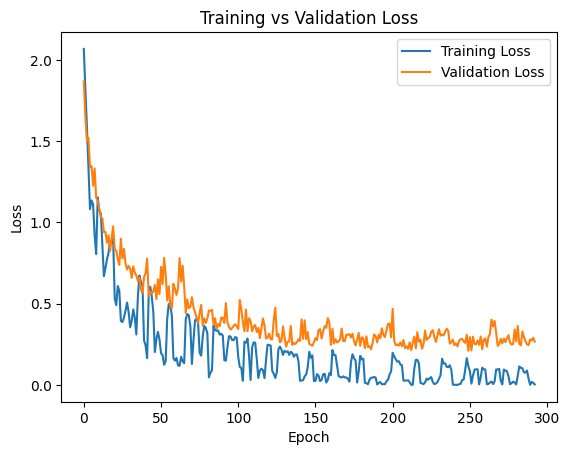

In [ ]:
# Set the early stopping callback
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=50,
        restore_best_weights=True,
        mode='auto'
    )
]

# Fit the model
history = model.fit(
    train_ds,
    epochs=500,
    validation_data=val_ds,
    callbacks=callbacks,
    steps_per_epoch=100,
    validation_steps=10
).history

# Plot training & validation loss
plt.plot(history['loss'], label='Training Loss', color='tab:blue')
plt.plot(history['val_loss'], label='Validation Loss', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

## Evaluation on the test set

Let's visualize a set of 10 images from the same class:

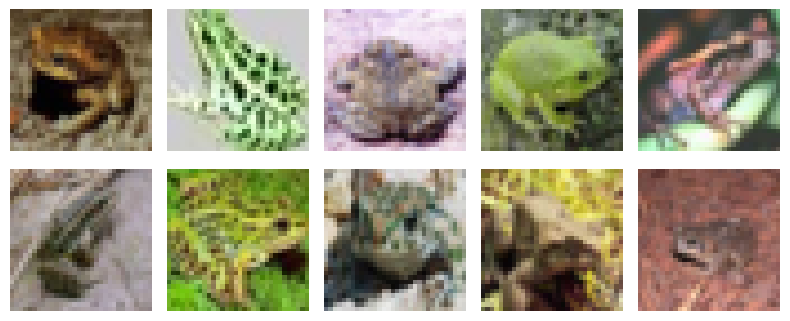

In [ ]:
# Generate an image set of 10 images from the same class
test_gen = CombinatorialGenerator(data=test_data, set_size_range=(10, 10), batch_size=1)
batch_x, _ = next(iter(test_gen.generate()))
image_set = batch_x[0]

n_cols = 5 # Number of images per row
n_rows = int(np.ceil(len(image_set) / n_cols))

plt.figure(figsize=(8, 1.75 * n_rows))

for i, img in enumerate(image_set):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

We evaluate the trained model’s Contextualized Image Classification accuracy on input sets ranging in size from 1 to 20

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.8050 - loss: 1.2490


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9303 - loss: 0.2666
3330/3330 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9780 - loss: 0.0779
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9879 - loss: 0.0342
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9969 - loss: 0.0140
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9961 - loss: 0.0103
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9973 - loss: 0.0049
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9998 - loss: 0.0022
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9995 - loss: 0.0024
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 1.0000 - loss: 4.9196e-04
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 1.0000 - loss: 3.4767e-04
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 1.0000 - loss: 1.5148e-04
760/760 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 1.0000 - loss: 3.6977e-04
710/710 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 1.0000 - l

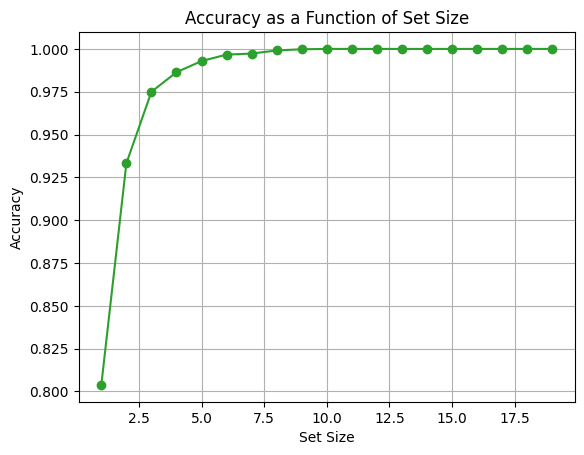

In [ ]:
output_signature = (
    tf.TensorSpec(shape=(None, None, 32, 32, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(None,), dtype=tf.int32)
)

accuracies = []
for i in range(1, 20):
    test_gen = CombinatorialGenerator(
        test_data,
        set_size_range=(i, i),
        batch_size=1,
    )

    test_ds = tf.data.Dataset.from_generator(
      test_gen.generate,
      output_signature=output_signature
    )

    _, accuracy = model.evaluate(test_ds)
    accuracies.append(accuracy)

# Plot accuracies vs set size
plt.plot(range(1, 20), accuracies, marker='o', color='tab:green')
plt.xlabel('Set Size')
plt.ylabel('Accuracy')
plt.title('Accuracy as a Function of Set Size')
plt.grid(True)
plt.show()